In [5]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/c0/a774286d0383419f558deb27096e5de9f9facd6c27df8e9f9af6fba2f77e/tensorflow-2.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.1 MB/s eta 0:00:00
  Obtaining dependency information for libclang>=13.0.0 from https://files.pythonhosted.org/packages/ea/df/55525e489c43f9dbb6c

In [18]:
pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for pynndescent>=0.5 from https://files.pythonhosted.org/packages/4e/82/0b9851a2fd4da9b57d7931446f5ebab92a98f1f35d3dc0dae5f9ed50a462/pynndescent-0.5.11-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 1.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86837 sha256=aab06ee6f0135e9674c04f6ada2706e67ffeaece511e1a6bab603ba5bb29ddd9
  Stored in directory: /home/6ac0320a-3e73-4c98-a38f-b78464dd94aa/.cache/pip/wheels/de/07/2e/814a6ee82e37528f2044a609a431028375b149bc31f03c0e27
Successfully built umap-learn
Note: you may need to restart the kernel to use updated packages.


In [114]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import pandas as pd
import umap
import plotly.express as px
from IPython.display import display

In [116]:
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', True)

In [118]:
#Reading Publibike availability data
dfPubliBikeAvailability = pd.read_csv("data/bike-availability-All-Stations_hourly.csv", encoding='latin-1', sep=';')

In [120]:
#Prepareing Data
# TODO---> Vielleicht auch nur mal genau eine Woche nutzen zum trainieren der Daten, da eine Woche ein recht gutes Pattern ist.
dfPubliBikeAvailability = dfPubliBikeAvailability.rename(columns={"Abfragezeit": "timestamp"})
dfPubliBikeAvailability["timestamp"] = pd.to_datetime(dfPubliBikeAvailability["timestamp"])
dfPubliBikeAvailability["dayofweek"] = dfPubliBikeAvailability["timestamp"].dt.weekday
dfPubliBikeAvailability["hourofday"] = dfPubliBikeAvailability["timestamp"].dt.hour

In [122]:
# Want to have 3 Groups with simular distribution
dfPubliBikeAvailability['bike_availability'] = dfPubliBikeAvailability['Bike']

dfPubliBikeAvailability['e-bike_availability'] = dfPubliBikeAvailability['EBike']

In [124]:
#Assining the availability into 3 Groups;  Group "0" --> Available bikes = 0-1; Group "1" --> Available bikes = 2-4; Group "2" --> 5 or more
dfPubliBikeAvailability['bike_availability'] = [0 if (i<2) else i for i in dfPubliBikeAvailability['bike_availability']]
dfPubliBikeAvailability['bike_availability'] = [1 if (1<i<5) else i for i in dfPubliBikeAvailability['bike_availability']]
dfPubliBikeAvailability['bike_availability'] = [2 if (i>4) else i for i in dfPubliBikeAvailability['bike_availability']]

dfPubliBikeAvailability['e-bike_availability'] = [0 if (i<2) else i for i in dfPubliBikeAvailability['e-bike_availability']]
dfPubliBikeAvailability['e-bike_availability'] = [1 if (1<i<5) else i for i in dfPubliBikeAvailability['e-bike_availability']]
dfPubliBikeAvailability['e-bike_availability'] = [2 if (i>4) else i for i in dfPubliBikeAvailability['e-bike_availability']]

In [125]:
print(dfPubliBikeAvailability)

                  timestamp   id  Bike  EBike  dayofweek  hourofday  \
0       2022-07-07 15:00:00  804     6      5          3         15   
1       2022-07-07 15:00:00  417     4      1          3         15   
2       2022-07-07 15:00:00  195    10      1          3         15   
3       2022-07-07 15:00:00  486     1      5          3         15   
4       2022-07-07 15:00:00  228     2      0          3         15   
...                     ...  ...   ...    ...        ...        ...   
2766396 2023-11-21 12:00:00  468     0      1          1         12   
2766397 2023-11-21 12:00:00  479     0      4          1         12   
2766398 2023-11-21 12:00:00  213     1      1          1         12   
2766399 2023-11-21 12:00:00  411     4     20          1         12   
2766400 2023-11-21 12:00:00  122     7      5          1         12   

         bike_availability  e-bike_availability  
0                        2                    2  
1                        1                    0

In [128]:
# Get all unique station IDs
all_station_ids = dfPubliBikeAvailability['id'].unique()

# Print the unique station IDs
print("All Station IDs:")
print(all_station_ids)

All Station IDs:
[804 417 195 486 228 327 415 412 216 468 292 196 217 178 676 298 229 258
 472 303 602 324 681 322 308 187 546 353 219 469 465 194 191 118 259 677
 592 321 549 371 186 317 597 296 307 329 682 218 261 221 555 485 815 181
 673 192 179 252 244 255 463 422 462 464 311 260 669 683 198 190 306 372
 253 304 220 309 204 177 300 197 333 476 254 740 456 232 119 548 212 473
 201 591 484 595 203 318 590 180 271 553 175 174 475 459 312 423 648 315
 413 302 596 594 671 305 122 185 222 231 593 814 189 224 295 474 294 481
 497 414 199 176 674 117 326 257 230 121 672 226 478 816 667 320 328 325
 299 193 461 223 554 421 225 477 675 470 330 491 227 202 251 668 665 457
 291 550 331 314 416 184 420 482 188 301 293 348 663 726 316 479 419 290
 352 250 471 183 616 114 256 466 319 480 310 511 411 483 323 297 545 213
 182 460 313 332 467 547 552 680 262 214 215 589 670 347 458 772 666 418
 551 818 820 374 819 821 822 825 824 823 826 828 829 830 834 835 841 843
 842 349 242 867 877 878 882 883 5

In [198]:
# Filter the DataFrame based on the specified station ID
filtered_df = dfPubliBikeAvailability[dfPubliBikeAvailability['id'] == 230]

In [200]:
print(filtered_df)

                  timestamp   id  Bike  EBike  dayofweek  hourofday  \
134     2022-07-07 15:00:00  230     0      1          3         15   
354     2022-07-07 16:00:00  230     1      1          3         16   
572     2022-07-07 17:00:00  230     0      2          3         17   
788     2022-07-07 18:00:00  230     1      9          3         18   
1007    2022-07-07 19:00:00  230     0      3          3         19   
...                     ...  ...   ...    ...        ...        ...   
2765294 2023-11-21 08:00:00  230     0      0          1          8   
2765456 2023-11-21 09:00:00  230     0      0          1          9   
2765695 2023-11-21 10:00:00  230     2      0          1         10   
2765934 2023-11-21 11:00:00  230     2      0          1         11   
2766211 2023-11-21 12:00:00  230     1      1          1         12   

         bike_availability  e-bike_availability weekday_time  
134                      0                    0         3-15  
354                  

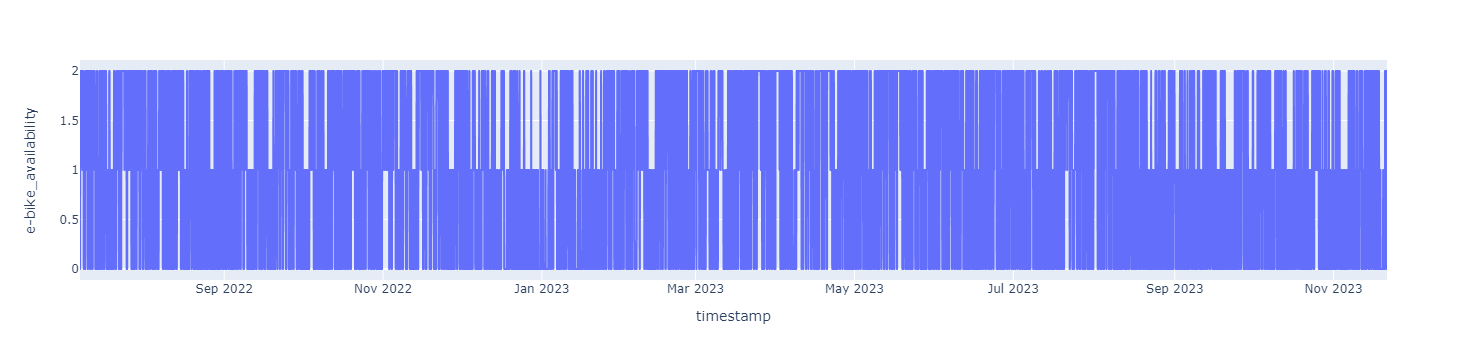

In [206]:
#Plot availability Groups over Time
fig = px.line(filtered_df, x="timestamp", y="e-bike_availability")

fig.show()

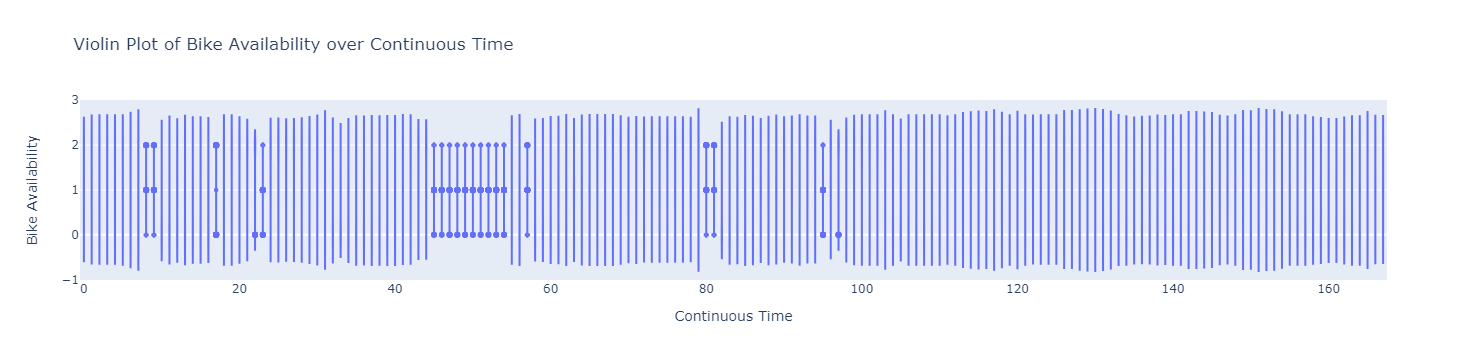

In [208]:
# Create a continuous numerical representation for the x-axis
filtered_df.loc[:,'continuous_time'] = filtered_df['dayofweek'] * 24 + filtered_df['hourofday']

# Create a violin plot
fig = px.violin(filtered_df, x='continuous_time', y='e-bike_availability',
                labels={'continuous_time': 'Continuous Time', 'e-bike_availability': 'Bike Availability'},
                title='Violin Plot of Bike Availability over Continuous Time')

# Show the plot
fig.show()

In [ ]:
#Plot the histogram of availability just to see if the distribution over the three availavility groups is simular
plt.hist(dfPubliBikeAvailability['bike_availability'], fill=False, histtype='step', label="length", density="True", bins = 100)
plt.show()